In [1]:
import xarray
import os
import pandas as pd
import numpy as np
import dask.dataframe as dd
import math

from Preprocessing import *

prep = Preprocessing()

In [2]:
from Preprocessing import *
merged_hornsea = pd.read_parquet("preprocessed_hornsea_with_energy.parquet")
merged_pes = pd.read_parquet("preprocessed_pes_with_energy.parquet")
merged_demand = pd.read_parquet("preprocessed_demand_with_energy.parquet")

In [ ]:
# from Preprocessing import *

# prep = Preprocessing()

# merged_hornsea = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_hornsea":"nc_files", "ncep_gfs_hornsea":"nc_files"},
#                                               deployment = False, merge_with_outage_data = True, json_file_path = "nc_files/REMIT", energy_data_dict = {"Energy_data":"csv_files"},
#                                               non_numerical_columns = ["unavailabilityType", "affectedUnit"],
#                                               fft = False, )

# merged_pes = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_pes":"nc_files", "ncep_gfs_pes":"nc_files"},
#           deployment = False, merge_with_outage_data = False, energy_data_dict = {"Energy_data":"csv_files"},
#                                               non_numerical_columns = ["unavailabilityType", "affectedUnit"],
#                                               fft = False, )

# merged_demand = prep.perform_preprocessing_pipeline(geo_data_dict = {"dwd_icon_eu_demand":"nc_files", "ncep_gfs_demand":"nc_files"},
#           deployment = False, merge_with_outage_data = True, energy_data_dict = {"Energy_data":"csv_files"},
#                                               non_numerical_columns = ["unavailabilityType", "affectedUnit"],
#                                               fft = False, )

In [4]:
# merged_hornsea.to_parquet("preprocessed_hornsea_with_energy.parquet")
# merged_pes.to_parquet("preprocessed_pes_with_energy.parquet")
# merged_demand.to_parquet("preprocessed_demand_with_energy.parquet")

In [3]:
import importlib
from Preprocessing import *

feature_engineerer_wind = FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit', "outage"])
feature_engineerer_wind.perform_feature_engineering(merged_hornsea, deployment = False)

feature_engineerer_solar = FeatureEngineerer(label = "Solar_MWh_credit")
feature_engineerer_solar.perform_feature_engineering(merged_pes, deployment = False)

merged_pes_simple = merged_pes[['solar_down_rad', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_solar_baseline = FeatureEngineerer(label = 'Solar_MWh_credit')
feature_engineerer_solar_baseline.perform_feature_engineering(merged_pes_simple, deployment = False)

merged_hornsea_simple = merged_hornsea[['wind_speed_100', 'Solar_MWh_credit', 'Wind_MWh_credit']]
feature_engineerer_wind_baseline = FeatureEngineerer(label = 'Wind_MWh_credit')
feature_engineerer_wind_baseline.perform_feature_engineering(merged_hornsea_simple, deployment = False)

### __Wind Energy Forecast__

__baseline__

In [6]:
import model_utils
import importlib
importlib.reload(model_utils)

quantiles = np.arange(0.1, 1.0, 0.1)

# Specify model save directory
model_save_dir_qr = "qr_model_wind"

qr_model_wind = model_utils.QuantileRegressorModel(feature_engineerer_wind_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
qr_model_wind.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_wind.pinball_score()}")

Saved Quantile Regressor model for quantile 0.1 to qr_model_wind\qr_model_quantile_0.1.pkl
Saved Quantile Regressor model for quantile 0.2 to qr_model_wind\qr_model_quantile_0.2.pkl
Saved Quantile Regressor model for quantile 0.30000000000000004 to qr_model_wind\qr_model_quantile_0.30000000000000004.pkl
Saved Quantile Regressor model for quantile 0.4 to qr_model_wind\qr_model_quantile_0.4.pkl
Saved Quantile Regressor model for quantile 0.5 to qr_model_wind\qr_model_quantile_0.5.pkl
Saved Quantile Regressor model for quantile 0.6 to qr_model_wind\qr_model_quantile_0.6.pkl
Saved Quantile Regressor model for quantile 0.7000000000000001 to qr_model_wind\qr_model_quantile_0.7000000000000001.pkl
Saved Quantile Regressor model for quantile 0.8 to qr_model_wind\qr_model_quantile_0.8.pkl
Saved Quantile Regressor model for quantile 0.9 to qr_model_wind\qr_model_quantile_0.9.pkl
Quantile Regressor Pinball Score: 53.08909151412246


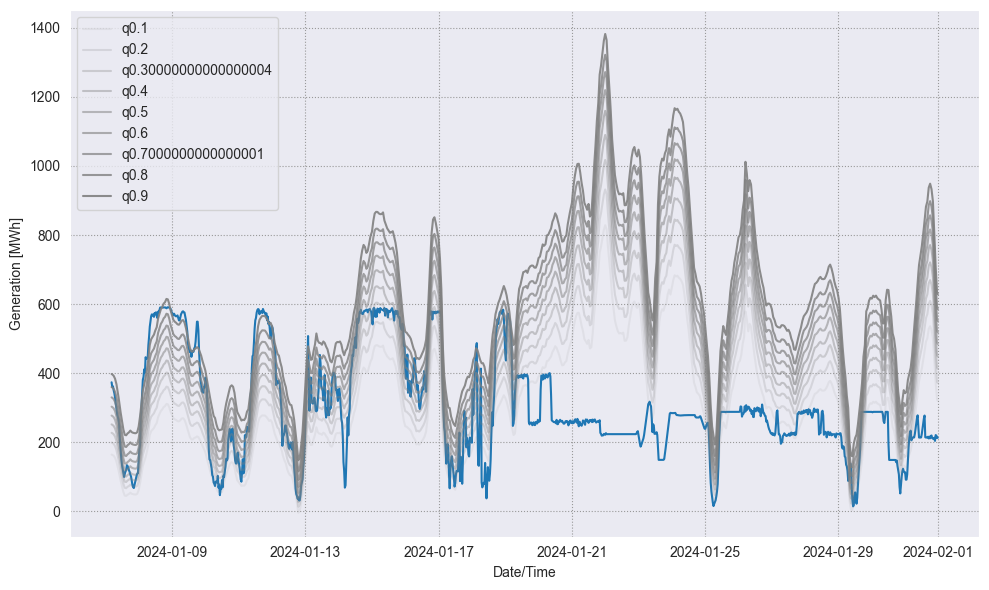

In [7]:
total_rows = len(merged_hornsea)  # Gesamtanzahl der Zeilen im DataFrame
last_10_percent_rows = int(0.1 * total_rows + 1)  # Anzahl der letzten 10% Zeilen

# Extrahieren der letzten 10% des DataFrames
wind_testset = merged_hornsea.tail(last_10_percent_rows)

qr_model_wind.plot_quantils(wind_testset, qr_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

__xgboost__

In [20]:
feature_engineerer_wind2 = FeatureEngineerer(label = 'Wind_MWh_credit', columns_to_ohe = ['unavailabilityType', 'affectedUnit', "outage"])
feature_engineerer_wind2.perform_feature_engineering(merged_hornsea.drop(["rel_hum", "temp"], axis = 1), deployment = False)

In [21]:
import model_utils


quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_wind"

hyperparams = {"objective": "reg:quantileerror",
            "tree_method": "hist",
            "quantile_alpha": quantiles,
            "learning_rate": 0.01,
            "max_depth": 10}

xgboost_model_wind = model_utils.XGBoostModel(feature_engineerer_wind, quantiles=quantiles, model_save_dir=model_save_dir_xgboost, load_pretrained=False,
                                              hyperparams = hyperparams,
                                              num_boost_round = 100,
                                              )
xgboost_model_wind.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_wind.pinball_score()}")

[0]	Train-quantile:98.06430	Val-quantile:90.12834
[1]	Train-quantile:96.99796	Val-quantile:89.32436
[2]	Train-quantile:95.94421	Val-quantile:88.53500
[3]	Train-quantile:94.90201	Val-quantile:87.76121
[4]	Train-quantile:93.87272	Val-quantile:86.99158
[5]	Train-quantile:92.85347	Val-quantile:86.23442
[6]	Train-quantile:91.84682	Val-quantile:85.48706
[7]	Train-quantile:90.85103	Val-quantile:84.75578
[8]	Train-quantile:89.86740	Val-quantile:84.03258
[9]	Train-quantile:88.89458	Val-quantile:83.31511
[10]	Train-quantile:87.93201	Val-quantile:82.60919
[11]	Train-quantile:86.97864	Val-quantile:81.90858
[12]	Train-quantile:86.03941	Val-quantile:81.22166
[13]	Train-quantile:85.10978	Val-quantile:80.54088
[14]	Train-quantile:84.19202	Val-quantile:79.87980
[15]	Train-quantile:83.28563	Val-quantile:79.23041
[16]	Train-quantile:82.38982	Val-quantile:78.58692
[17]	Train-quantile:81.50444	Val-quantile:77.95459
[18]	Train-quantile:80.62709	Val-quantile:77.32391
[19]	Train-quantile:79.75906	Val-quantile

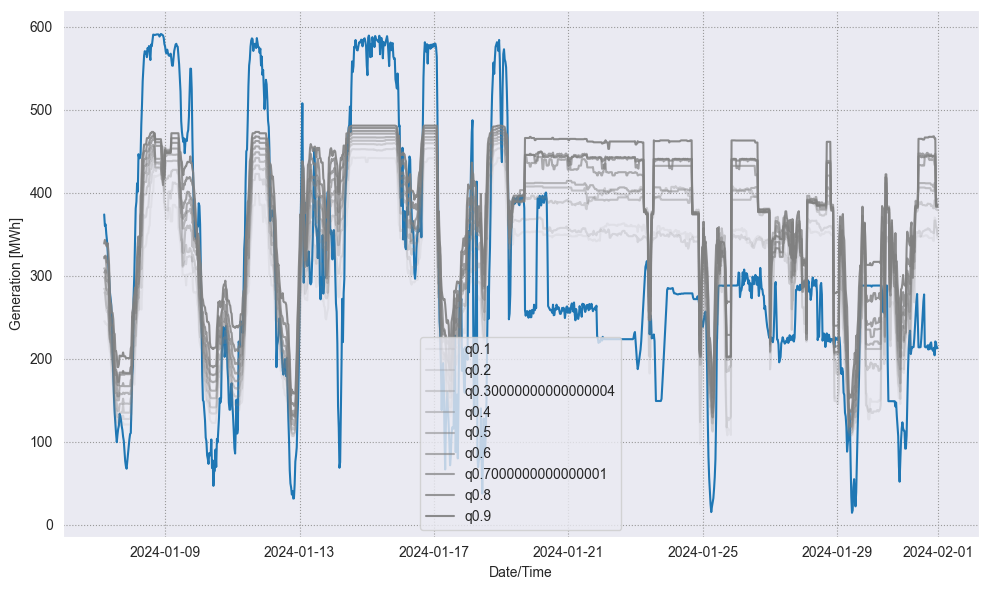

In [22]:
total_rows = len(merged_hornsea)  # Gesamtanzahl der Zeilen im DataFrame
last_10_percent_rows = int(0.1 * total_rows + 1)  # Anzahl der letzten 10% Zeilen

# Extrahieren der letzten 10% des DataFrames
wind_testset = merged_hornsea.tail(last_10_percent_rows)

xgboost_model_wind.plot_quantils(x=wind_testset, y=xgboost_model_wind.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

(43, 2)


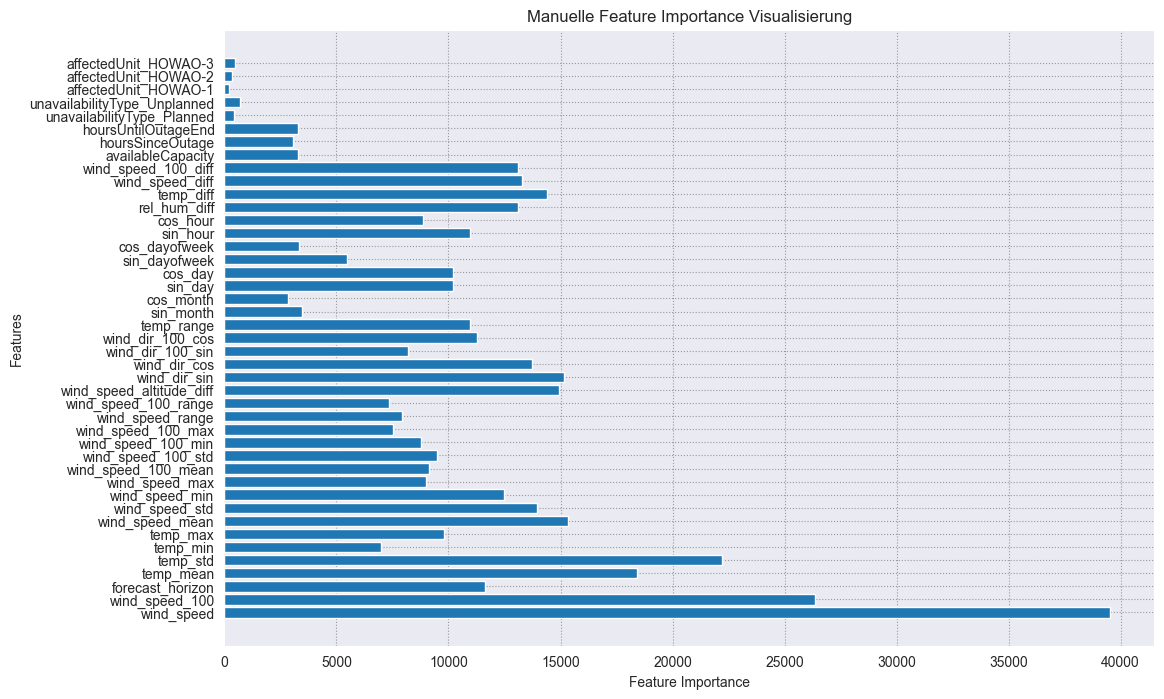

In [23]:
# Feature-Wichtigkeiten abrufen
import matplotlib.pylab as plt

booster = xgboost_model_wind.booster
importance_dict = booster.get_score(importance_type='weight')
# In ein Pandas DataFrame umwandeln für einfache Verarbeitung
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
print(importance_df.shape)
# Nach Wichtigkeit sortieren
# importance_df = importance_df.sort_values(by='Index', ascending=False)

# Plotten
plt.figure(figsize=(12, 8))  # Größe anpassen
plt.barh(
         importance_df['Feature'], 
         importance_df['Importance']
         )
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.grid(True)
plt.title('Manuelle Feature Importance Visualisierung')
plt.show()

### __Solar Energy Forecast__

__baseline modell__

In [6]:
quantiles = np.arange(0.1, 1.0, 0.1)
import model_utils

# Specify model save directory
model_save_dir_qr = "qr_model_solar"

qr_model_solar = model_utils.QuantileRegressorModel(feature_engineerer_solar_baseline, quantiles, model_save_dir=model_save_dir_qr, load_pretrained=False)
qr_model_solar.train_and_predict()  # This will skip training for already loaded models
print(f"Quantile Regressor Pinball Score: {qr_model_solar.pinball_score()}")

Saved Quantile Regressor model for quantile 0.1 to qr_model_solar\qr_model_quantile_0.1.pkl
Saved Quantile Regressor model for quantile 0.2 to qr_model_solar\qr_model_quantile_0.2.pkl
Saved Quantile Regressor model for quantile 0.30000000000000004 to qr_model_solar\qr_model_quantile_0.30000000000000004.pkl
Saved Quantile Regressor model for quantile 0.4 to qr_model_solar\qr_model_quantile_0.4.pkl
Saved Quantile Regressor model for quantile 0.5 to qr_model_solar\qr_model_quantile_0.5.pkl
Saved Quantile Regressor model for quantile 0.6 to qr_model_solar\qr_model_quantile_0.6.pkl
Saved Quantile Regressor model for quantile 0.7000000000000001 to qr_model_solar\qr_model_quantile_0.7000000000000001.pkl
Saved Quantile Regressor model for quantile 0.8 to qr_model_solar\qr_model_quantile_0.8.pkl
Saved Quantile Regressor model for quantile 0.9 to qr_model_solar\qr_model_quantile_0.9.pkl
Quantile Regressor Pinball Score: 13.779483166533769


In [ ]:
total_rows = len(merged_pes)  # Gesamtanzahl der Zeilen im DataFrame
last_10_percent_rows = int(0.1 * total_rows + 1)  # Anzahl der letzten 10% Zeilen

# Extrahieren der letzten 10% des DataFrames
solar_testset = merged_pes.tail(last_10_percent_rows)

qr_model_solar.plot_quantils(x=solar_testset, y=qr_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

__xgboost__

In [4]:
import model_utils
quantiles = np.arange(0.1, 1.0, 0.1)

model_save_dir_xgboost = "xgboost_model_solar"

hyperparams = {"objective": "reg:quantileerror",
            "quantile_alpha": quantiles,
            "learning_rate": 0.001,
            "max_depth": 6
            }

xgboost_model_solar = model_utils.XGBoostModel(feature_engineerer_solar, quantiles=quantiles,
                                               hyperparams = hyperparams,
                                               num_boost_round = 100,
                                               model_save_dir=model_save_dir_xgboost, load_pretrained=False)
xgboost_model_solar.train_and_predict()  # This will skip training if the model is already loaded
print(f"XGBoost Pinball Score: {xgboost_model_solar.pinball_score()}")

[0]	Train-quantile:46.07130	Val-quantile:96.73654
[1]	Train-quantile:46.02175	Val-quantile:96.62820
[2]	Train-quantile:45.97227	Val-quantile:96.51997
[3]	Train-quantile:45.92282	Val-quantile:96.41187
[4]	Train-quantile:45.87331	Val-quantile:96.30341
[5]	Train-quantile:45.82386	Val-quantile:96.19530
[6]	Train-quantile:45.77439	Val-quantile:96.08715
[7]	Train-quantile:45.72472	Val-quantile:95.97861
[8]	Train-quantile:45.67488	Val-quantile:95.87004
[9]	Train-quantile:45.62513	Val-quantile:95.76161
[10]	Train-quantile:45.57528	Val-quantile:95.65331
[11]	Train-quantile:45.52543	Val-quantile:95.54515
[12]	Train-quantile:45.47613	Val-quantile:95.43681
[13]	Train-quantile:45.42732	Val-quantile:95.32940
[14]	Train-quantile:45.37938	Val-quantile:95.22215
[15]	Train-quantile:45.33215	Val-quantile:95.11417
[16]	Train-quantile:45.28513	Val-quantile:95.00573
[17]	Train-quantile:45.23816	Val-quantile:94.89749
[18]	Train-quantile:45.19130	Val-quantile:94.78885
[19]	Train-quantile:45.14449	Val-quantile

In [ ]:
import comp_utils
import pandas as pd

solar_pred = xgboost_model_solar.predict(feature_engineerer_solar.X_test)
wind_pred = xgboost_model_wind.predict(feature_engineerer_wind.X_test)

def create_submission_data(original_data, wind_prediction, solar_prediction, date:str, api_key_file:str = "team_key.txt"):

    rebase_api_client = comp_utils.RebaseAPI(api_key = open(api_key_file).read())
    # read the required timestamps for the next day
    market_day = pd.DataFrame({"datetime":comp_utils.day_ahead_market_times(today_date=pd.to_datetime(date))})

    prediction = dict()

    for key in wind_prediction.keys():
        prediction[key] = wind_prediction[key] + solar_prediction[key]

    # get the datetime values from the data which was used to predict the forecast
    index = original_data[-prediction["0.1"].shape[0]:].index
    # merge the predictions with the timestamps to make a prediction
    forecasts = pd.DataFrame(prediction, index = index).reset_index().merge(market_day, left_on = "dtm", right_on = "datetime")
    forecasts.columns = ["dtm", "10", "20", "30", "40", "50", "60", "70", "80", "90", "datetime"]

    submissions = list()

    for index, row in forecasts.iterrows():
        submissions.append({"timestamp": str(pd.to_datetime(row.dtm)).replace(" ", "T"),
                            "market_bid": 500.5,
                            "probalistic_forecast": row[["10", "20", "30", "40", "50", "60", "70", "80", "90"]].to_dict()})
        
    return submissions


create_submission_data(merged_hornsea, wind_pred, solar_pred, "2024-05-17")

In [ ]:
total_rows = len(merged_pes)  # Gesamtanzahl der Zeilen im DataFrame
last_10_percent_rows = int(0.1 * total_rows + 1)  # Anzahl der letzten 10% Zeilen

# Extrahieren der letzten 10% des DataFrames
solar_testset = merged_pes.tail(last_10_percent_rows)

xgboost_model_solar.plot_quantils(x=solar_testset, y=xgboost_model_solar.q_predictions, quantiles=np.arange(0.1, 1.0, 0.1))

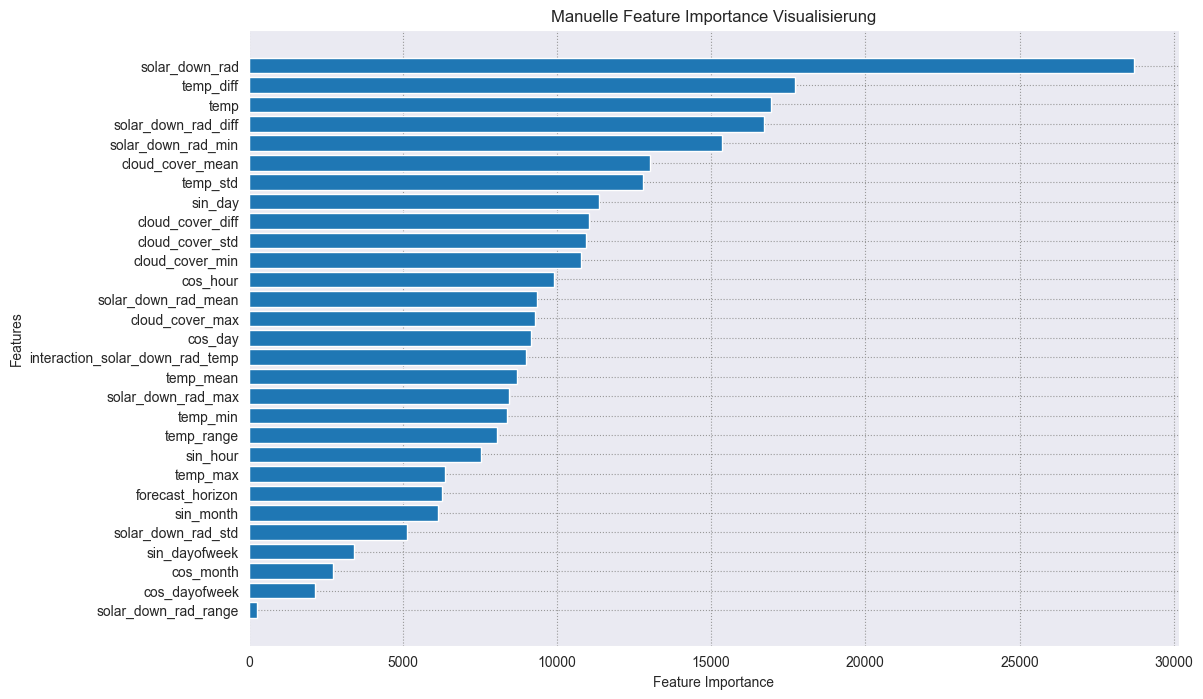

In [28]:
# Feature-Wichtigkeiten abrufen
import matplotlib.pylab as plt

booster = xgboost_model_solar.booster
importance_dict = booster.get_score(importance_type='weight')

# In ein Pandas DataFrame umwandeln für einfache Verarbeitung
importance_df = pd.DataFrame(list(importance_dict.items()), columns=['Feature', 'Importance'])
# Nach Wichtigkeit sortieren
importance_df = importance_df.sort_values(by='Importance')


# Plotten
plt.figure(figsize=(12, 8))  # Größe anpassen
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.grid(True)
plt.title('Manuelle Feature Importance Visualisierung')
plt.show()

### __Lightgbm implementation__

In [13]:
import lightgbm as lgb
importlib.reload(model_utils)

quantiles = [x for x in np.arange(0.1, 1.0, 0.1)]
qr_solar_lightgbm = {}
qr_solar_lightgbm["true"] = feature_engineerer_solar.y_test.values
#out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr_lightgbm = lgb.LGBMRegressor(objective='quantile', alpha=quantile)
    qr_lightgbm.fit(feature_engineerer_solar.X_train, feature_engineerer_solar.y_train)
    qr_solar_lightgbm[str(quantile)] = qr_lightgbm.predict(feature_engineerer_solar.X_test)

qr_solar_lightgbm_df = pd.DataFrame(qr_solar_lightgbm)
model_utils.pinball_score(qr_solar_lightgbm_df, quantiles=quantiles)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000542 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000057 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 1
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000053 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 255
[LightGBM] [Info] Number of data points in the train set: 48168, number of used features: 1
[LightGBM] 

8.507907722761146

In [14]:
quantiles = [x for x in np.arange(0.1, 1.0, 0.1)]
qr_wind_lightgbm = {}
qr_wind_lightgbm["true"] = feature_engineerer_wind.y_test.values
#out_bounds_predictions = np.zeros_like(y_true_mean, dtype=np.bool_)
for quantile in quantiles:
    qr_lightgbm_wind = lgb.LGBMRegressor(objective='quantile', alpha=quantile)
    qr_lightgbm_wind.fit(feature_engineerer_wind.X_train, feature_engineerer_wind.y_train)
    qr_wind_lightgbm[str(quantile)] = qr_lightgbm_wind.predict(feature_engineerer_wind.X_test)

qr_wind_lightgbm_df = pd.DataFrame(qr_wind_lightgbm)
model_utils.pinball_score(qr_wind_lightgbm_df, quantiles=quantiles)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8036
[LightGBM] [Info] Number of data points in the train set: 7538, number of used features: 46
[LightGBM] [Info] Start training from score 15.432500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8036
[LightGBM] [Info] Number of data points in the train set: 7538, number of used features: 46
[LightGBM] [Info] Start training from score 54.559002
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8036
[LightGBM] [Info] Number of data points in the train set: 7538, number of used features: 46
[LightGBM] [Info] Start trai

41.97877203749826

In [ ]:
importance_df = pd.DataFrame({
    'Feature': qr_lightgbm_wind.feature_name_,
    'Importance': qr_lightgbm_wind.feature_importances_
})

# Nach Wichtigkeit sortieren
#importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df["feature_name"] = merged_hornsea.drop(['Solar_MWh_credit', 'Wind_MWh_credit'], axis=1).columns
# Plotten der Feature Importance
plt.figure(figsize=(12, 8))  # Plot-Größe anpassen
plt.barh(importance_df['feature_name'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Manuelle Feature Importance Visualisierung Lightgbm')
plt.grid(True)
plt.show()

In [ ]:
importance_df = pd.DataFrame({
    'Feature': qr_lightgbm.feature_name_,
    'Importance': qr_lightgbm.feature_importances_
})

# Nach Wichtigkeit sortieren
#importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df["feature_name"] = merged_pes.drop(['Solar_MWh_credit', 'Wind_MWh_credit'], axis=1).columns
# Plotten der Feature Importance
plt.figure(figsize=(12, 8))  # Plot-Größe anpassen
plt.barh(importance_df['feature_name'], importance_df['Importance'])
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Manuelle Feature Importance Visualisierung Lightgbm')
plt.grid(True)
plt.show()